Rows in data: 252


XONRETURNS     1.362199
XONSTRATEGY    1.921452
dtype: float64

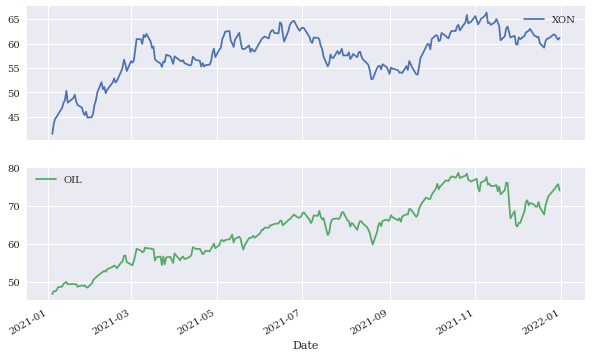

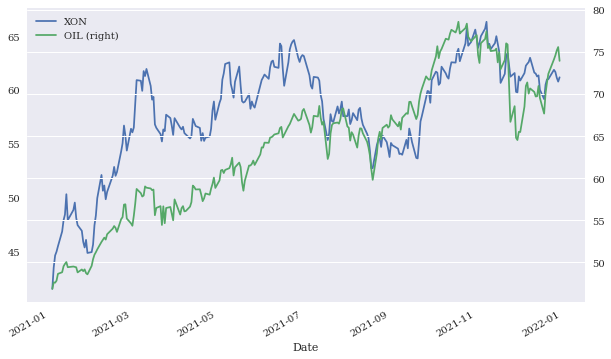

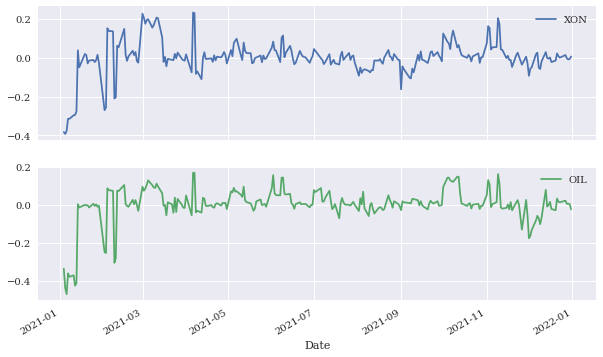

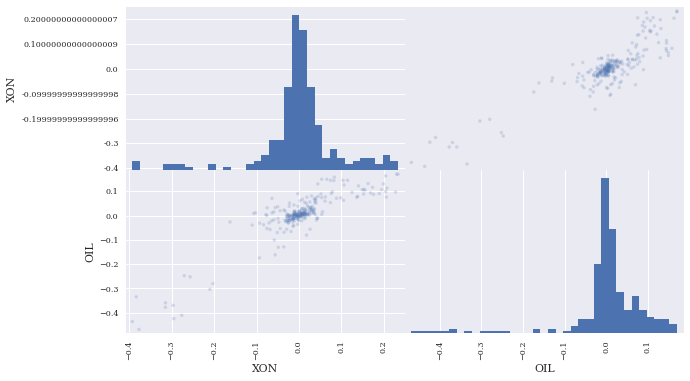

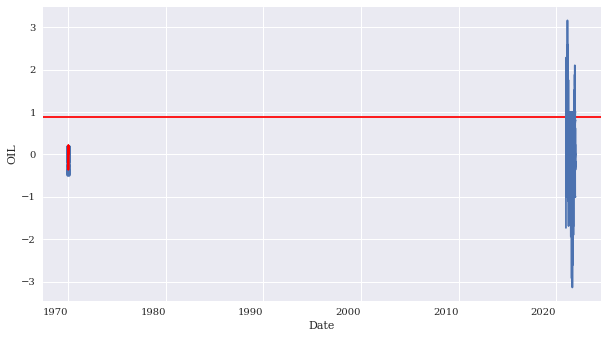

In [1]:
from ast import increment_lineno
import numpy as np
import pandas as pd 
from pylab import plt, mpl 
import math
import matplotlib as plt 

m = 1000000 #total wealth 
 
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
#importing data with both sets of time series
raw = pd.read_csv('E:\My Drive\Documents\Economics of Financial Markets\Model\historicaldatareversed.csv', index_col=0, parse_dates=True)
#creating dataframe
data = pd.DataFrame(raw[['XON','OIL']]).dropna()
#looking at end of dataset
data.tail()

#plotting time series
data.plot(subplots=True,figsize=(10,6))
#plotting time series on same graph
data.loc[:'2021-12-31'].plot(secondary_y='OIL',figsize=(10,6))

#calculating logarithmic returns
returns = np.log(data / data.shift(1))
returns.head()
returns.dropna(inplace=True)
returns.plot(subplots=True, figsize=(10,6))

pd.plotting.scatter_matrix(returns, alpha =0.2, diagonal = 'hist', hist_kwds= {'bins':35}, figsize = (10,6))
#creating OLS regession graph
reg = np.polyfit(returns['XON'], returns['OIL'], deg = 1)
ax = returns.plot(kind = 'scatter', x = 'XON', y ='OIL',figsize = (10,6) )
ax.plot(returns['XON'], np.polyval(reg,returns['XON']), 'r', lw=2)
#intercept and correlation coeffecient
reg

#rolling correlation over time - not needed, but will be useful for improvements to model
ax = returns['XON'].rolling(window=21).corr(
                  returns['OIL']).plot(figsize=(10, 6))  
ax.axhline(returns.corr().iloc[0, 1], c='r');  
a = reg[1] #intercept
b = reg[0] #correlation coefficient
#estimated returns model
model = a + b * returns['OIL']
#statistical mispricing
data ['mispricing'] = returns['XON'] - model
data['mispricing'].plot(subplots=True,figsize=(10,6))
# historical mispricing average
data['average'] = 1/252 * np.sum(data['mispricing'])
data['average']

# historical mispricing standard deviation - should be constant or not?

data['stdev'] = np.std(data['mispricing'])
#z-scores

data['z'] = (data['mispricing'] - data['average']) / data['stdev']
data['z'].plot(subplots=True,figsize=(10,6))

data['z']

#1 Buy XON and sell OIL
data['BUY'] = np.where(data['z'] < -2, 1, 0)
#-1 Sell XON and buy OIL
data['SELL'] = np.where(data['z'] > 2, -1, 0)

data['BUY'].plot(subplots=True,figsize=(10,6))

data['SELL'].plot(subplots=True,figsize=(10,6))

df = pd.DataFrame(data, columns = ['BUY', 'SELL'])
df
#in_first = set(data['BUY'])
#second_list = set(data['SELL'])




data['SIGNAL'] = np.where(data['z'] < -2, 1, 0) | np.where(data['z'] > 2,-1,0)
data['SIGNAL']
#converts trading signals into actual trade positions for XON

currentvalue = 0
previousvalue = 0

print("Rows in data: " + str(len(data.index)))
status =[0] * len(data.index)
c = 0

for row in data.itertuples():
    if previousvalue == 0:
        previousvalue = currentvalue
    
    currentvalue = row.SIGNAL
 
    if currentvalue == previousvalue:
        status[c]= currentvalue
    elif previousvalue == 0 and currentvalue == 1:
        status[c] = 1
    elif previousvalue == 1 and currentvalue == -1:
        previousvalue = -1
        status[c] = -1
    elif previousvalue == -1 and currentvalue == 1:
        previousvalue = 1
        status[c] = 1
    elif previousvalue == 0 and currentvalue == -1:
        previousvalue = -1    
        status[c] = -1
    elif currentvalue == 0:
        status[c] = previousvalue
    c+=1
    
    #print("Status len:" + str(len(status)))
    #print("Output: " + str( status[len(status)-1]))
    
#adds to dataframe
data["POSITIONXON"] = status


#converts XOM trading positions into trading positions for OIL to make return calculations easier to account for hedging
statusoil = []
for i in status:
    if i == 0:
        statusoil.append(0)
    elif i == 1:
        statusoil.append(-1)
    elif i == -1:
        statusoil.append(1)

data["POSITIONOIL"] = statusoil
#CHART FOR XOM TRADING POSITION
data['POSITIONXON'].plot(subplots=True,figsize=(10,6))



#CHART FOR OIL TRADING POSITION 
data['POSITIONOIL'].plot(subplots=True,figsize=(10,6))

data['XONRETURNS'] = np.log(data['XON'] / data['XON'].shift(1))  
data['XONSTRATEGY'] = data['POSITIONXON'].shift(1) * data['XONRETURNS']
data.round(4).head()
data.dropna(inplace = True)

np.exp(data[['XONRETURNS', 'XONSTRATEGY']].sum())
